# Monte Carlo Markov Chain sampling of COVID-19 infections

#### Author: leebond
#### Date: Feb 2020

In [1]:
import numpy as np
import scipy
import scipy.stats
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import os, re, sys

# from helper_fun_model import *
from mcmcHelperFunctions import *

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns',300)
pd.set_option('display.max_rows',300)

## Data source
#### source JHU

In [2]:
## Load data 
df = pd.read_csv("../data/daily_time_series_data_JHU.csv")

"""
Data Cleaning 
"""
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')
df.tail(3) # check new

,Province,Country,Date,Confirmed,Deaths,Recovered
2115,"San Antonio, TX",US,2020-02-22,1.0,0,0
2116,"Seattle, WA",US,2020-02-22,1.0,0,1
2117,"Tempe, AZ",US,2020-02-22,1.0,0,0


# Case 1: Simulate China infection numbers

In [3]:
case = df[df['Country']=='China'] # get all of China's infection numbers
case = case.groupby('Date').agg({'Confirmed':'sum','Deaths':'sum','Recovered':'sum'}).reset_index()

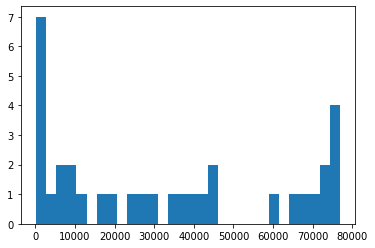

In [4]:
plt.hist(case['Confirmed'], bins = 30)
plt.show()

#### Using the daily change in infection number as a random variable we want to model
- the change in the infection numbers from day to day can tell us the force of infection per day. In other words, it can also be thought of as the infection rate which we could model as a random variable.
- to do so i simply do `diff()` which takes the first 'lag' of the infection column. Notice that the first row will not have any number since there is no 'lag'. Therefore, I fill the first record as 1 for simplicity yet it can't be 0 since there 'should' be some kind of new infection from day to day.

In [5]:
case['new infected'] = case['Confirmed'].diff().fillna(1)

In [6]:
case.head(10)

,Date,Confirmed,Deaths,Recovered,new infected
0,2020-01-20,144.0,0,0,1.0
1,2020-01-21,217.0,0,0,73.0
2,2020-01-22,547.0,17,28,330.0
3,2020-01-23,639.0,18,30,92.0
4,2020-01-24,916.0,26,36,277.0
5,2020-01-25,1399.0,42,39,483.0
6,2020-01-26,2062.0,56,49,663.0
7,2020-01-27,2863.0,82,58,801.0
8,2020-01-28,5494.0,131,101,2631.0
9,2020-01-29,6070.0,133,120,576.0


In [7]:
case.shape

(34, 5)

## EDA

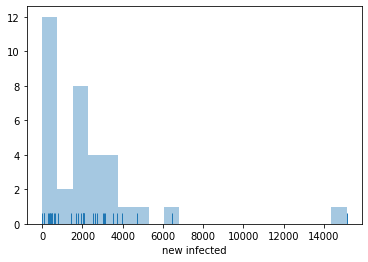

In [8]:
sb.distplot(case['new infected'], bins=20, kde=False, rug=True)

In [9]:
case = case[case['new infected']<14000]

### Creating a gamma fit to the data
- the belief distribution is that the infection rate follows a gamma distribution.
- A gamma distribution is continuous, does not take on negative values and its flexible since it takes on two parameters; shape and scale
- several research papers have used gamma to model infection rates (google abit and you will see many using gamma)

In [78]:
mu = case['new infected'].mean()
sigma = case['new infected'].std()
mu, sigma

(1868.060606060606, 1539.0999183653155)

In [79]:
(mu/sigma)**2, sigma**2/mu

(1.47315449025689, 1268.0683651412903)

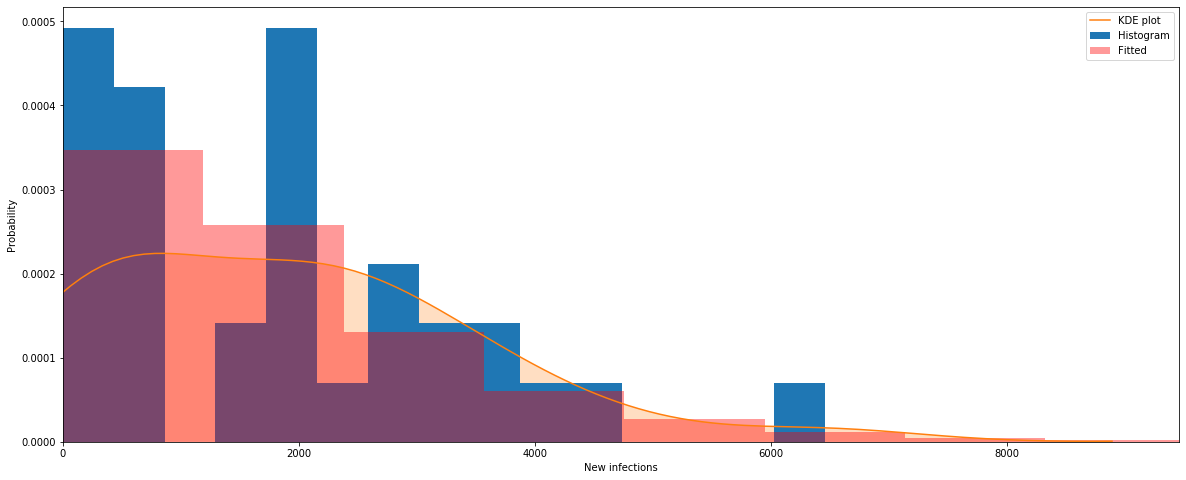

In [80]:
shape, scale = (mu/sigma)**2, sigma**2/mu
fig = plt.figure(figsize=(20,8))

gcount, gbins, ignored = plt.hist(case['new infected'], bins=15, normed=True, label='Histogram')
sb.kdeplot(case['new infected'], shade=True, label='KDE plot').set(xlim=(0))

g = np.random.gamma(shape, scale, 50000)
fcount, fbins, ignored = plt.hist(g, bins=15, normed=True, label='Fitted', alpha = 0.4, color='r')

plt.legend()
plt.ylabel("Probability")
plt.xlabel("New infections")
plt.show()

#### Some comments about the fitting
- The density plot is **missing some data** because we did not include counts from the earlier days of the outbreak (we have it but it is highly unreliable) 
- therefore the density distribution do not have new infection numbers that is near 0

# MCMC
- Why MCMC?
 - it offers us a robust method to draw samples from our posterior ie. allow us to bootstrap our data (new infection) to test a distribution
 - with the sampled distribution we can use MLE to find the parameters of the distribution
 - since our belief is a gamma distribution, we do the MLE for gamma
 - with the shape and scale parameters of gamma, we create an actual gamma distribution with these parameters, allowing us to forecast/predict samples that fall within the distribution of gamma. 
 - we do not know exactly what tomorrow's new infection number will be. But we can know the mean and variance of the gamma distribution + today's infection number = gives us tomorrow's infection count. 
 - Yes, it doesn't tell us in the future when and what the infection count will be (it doesnt forecast).

### Description
- MCMC
- use Metropolis Hastings' acceptance criterion
- checks for convergence using Gelman-Rubin's ratio

iter: 30000.0
Theta: 1561.5, Mean of samples: 1676.3, Stddev of samples: 1128.3
Theta: 3639.9, Mean of samples: 1576.0, Stddev of samples: 1118.9
Theta: 445.4, Mean of samples: 1889.0, Stddev of samples: 1420.1
Theta: 2376.2, Mean of samples: 1926.7, Stddev of samples: 1396.5
Theta: 2111.2, Mean of samples: 1858.8, Stddev of samples: 1415.9
Gelman Rubin convergence ratio: 1.196230744886216
iter: 65000.0
Theta: 4986.0, Mean of samples: 2123.7, Stddev of samples: 1483.4
Theta: 3220.5, Mean of samples: 2476.8, Stddev of samples: 2080.8
Theta: 1498.7, Mean of samples: 1892.2, Stddev of samples: 1499.4
Theta: 687.0, Mean of samples: 2058.6, Stddev of samples: 1589.8
Theta: 1670.3, Mean of samples: 1716.1, Stddev of samples: 1143.6
Gelman Rubin convergence ratio: 1.219978283945129
iter: 100000.0
Theta: 2146.2, Mean of samples: 1782.7, Stddev of samples: 1406.6
Theta: 1020.7, Mean of samples: 1447.0, Stddev of samples: 1045.8
Theta: 1661.1, Mean of samples: 2234.1, Stddev of samples: 2205.8
T

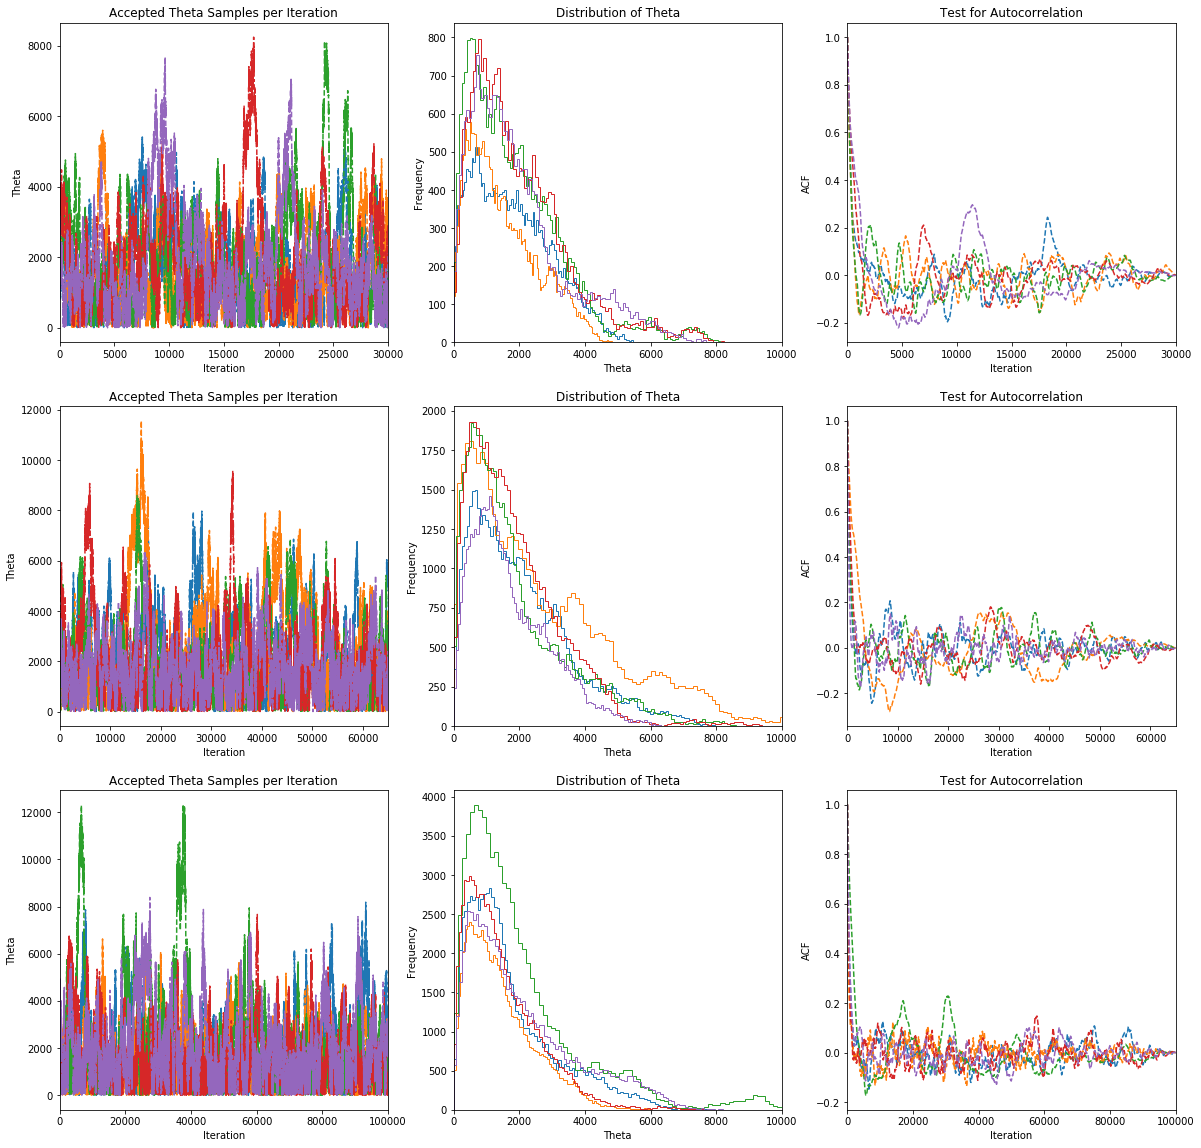

Wall time: 3min 45s


In [56]:
%%time
mcmc_samples = MCMC(shape, scale, niters = np.linspace(3e4,1e5,3), thetas = np.arange(1000, 3001, 500))

#### Result of MCMC Samples

In [57]:
a_i = b_i = 0
ab = [numericalMLEGamma(s) for s in mcmc_samples]
for x in ab:
    a_i += x[0]
    b_i += x[1]
print('Alpha: %s, Beta: %s' %(round(a_i/len(ab),1), round(b_i/len(ab),1)))
print('Mean infection count: %s' %(round(a_i/len(ab)*b_i/len(ab),1)))
print('Stddev infection count: %s' %(round(np.sqrt(a_i/len(ab)*b_i/len(ab)*b_i/len(ab)),1)))

Alpha: 1.6, Beta: 1192.2
Mean infection count: 1867.1
Stddev infection count: 1492.0


## Case 2: Simulate Hubei infection numbers

In [16]:
case_hubei = df[df['Province']=='Hubei']

In [17]:
case_hubei.head(10)

,Province,Country,Date,Confirmed,Deaths,Recovered
0,Hubei,China,2020-01-20,136.0,0,0
6,Hubei,China,2020-01-21,209.0,0,0
21,Hubei,China,2020-01-22,444.0,17,28
59,Hubei,China,2020-01-23,444.0,17,28
92,Hubei,China,2020-01-24,549.0,24,31
133,Hubei,China,2020-01-25,761.0,40,32
177,Hubei,China,2020-01-26,1058.0,52,42
224,Hubei,China,2020-01-27,1423.0,76,45
275,Hubei,China,2020-01-28,3554.0,125,80
327,Hubei,China,2020-01-29,3554.0,125,88


In [18]:
case_hubei['new infected'] = case_hubei['Confirmed'].diff().fillna(1)

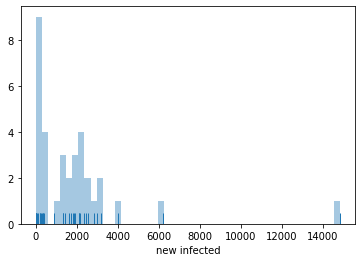

In [19]:
sb.distplot(case_hubei['new infected'], bins=20, kde=False, rug=True)

In [22]:
case_hubei = case_hubei[case_hubei['new infected']<14000]

In [23]:
mu = case_hubei['new infected'].mean()
sigma = case_hubei['new infected'].std()
mu, sigma

(1488.1515151515152, 1403.5909999268865)

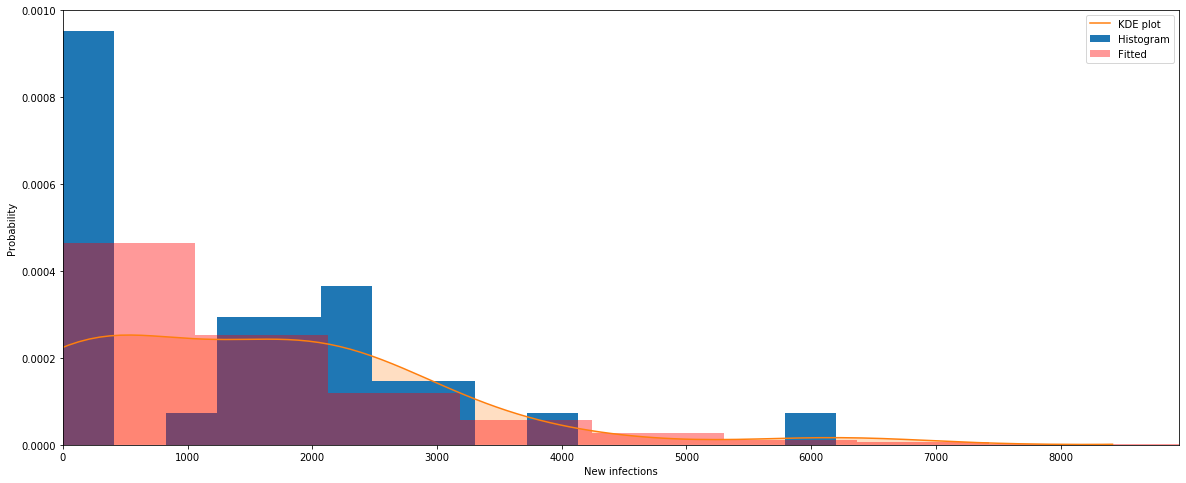

In [24]:
shape, scale = (mu/sigma)**2, sigma**2/mu
fig = plt.figure(figsize=(20,8))

gcount, gbins, ignored = plt.hist(case_hubei['new infected'], bins=15, normed=True, label='Histogram')
sb.kdeplot(case_hubei['new infected'], shade=True, label='KDE plot').set(xlim=(0))

g = np.random.gamma(shape, scale, 50000)
fcount, fbins, ignored = plt.hist(g, bins=15, normed=True, label='Fitted', alpha = 0.4, color='r')

plt.legend()
plt.ylabel("Probability")
plt.xlabel("New infections")
plt.show()

#### Kolmogorov-Smirnov test for goodness of fit

In [25]:
from scipy.stats import kstest
kstest(case_hubei['new infected'], 'gamma', args=[shape,scale])

KstestResult(statistic=0.4996612423065941, pvalue=3.836549191434545e-08)

iter: 30000.0
Theta: 1241.2, Mean of samples: 1260.5, Stddev of samples: 1015.9
Theta: 1380.3, Mean of samples: 1304.2, Stddev of samples: 973.4
Theta: 249.9, Mean of samples: 1747.2, Stddev of samples: 1592.1
Theta: 985.8, Mean of samples: 1827.6, Stddev of samples: 1485.5
Theta: 1951.4, Mean of samples: 1280.6, Stddev of samples: 1097.6
Gelman Rubin convergence ratio: 1.20276423570698
iter: 65000.0
Theta: 2084.1, Mean of samples: 1499.8, Stddev of samples: 1350.4
Theta: 2060.2, Mean of samples: 1379.0, Stddev of samples: 1158.7
Theta: 3933.4, Mean of samples: 1715.7, Stddev of samples: 1385.2
Theta: 2176.8, Mean of samples: 1949.7, Stddev of samples: 1703.5
Theta: 138.9, Mean of samples: 1527.5, Stddev of samples: 1385.9
Gelman Rubin convergence ratio: 1.2053697075460674
iter: 100000.0
Theta: 3252.3, Mean of samples: 1416.2, Stddev of samples: 1168.0
Theta: 318.5, Mean of samples: 1588.1, Stddev of samples: 1549.8
Theta: 635.0, Mean of samples: 1516.2, Stddev of samples: 1229.5
Theta

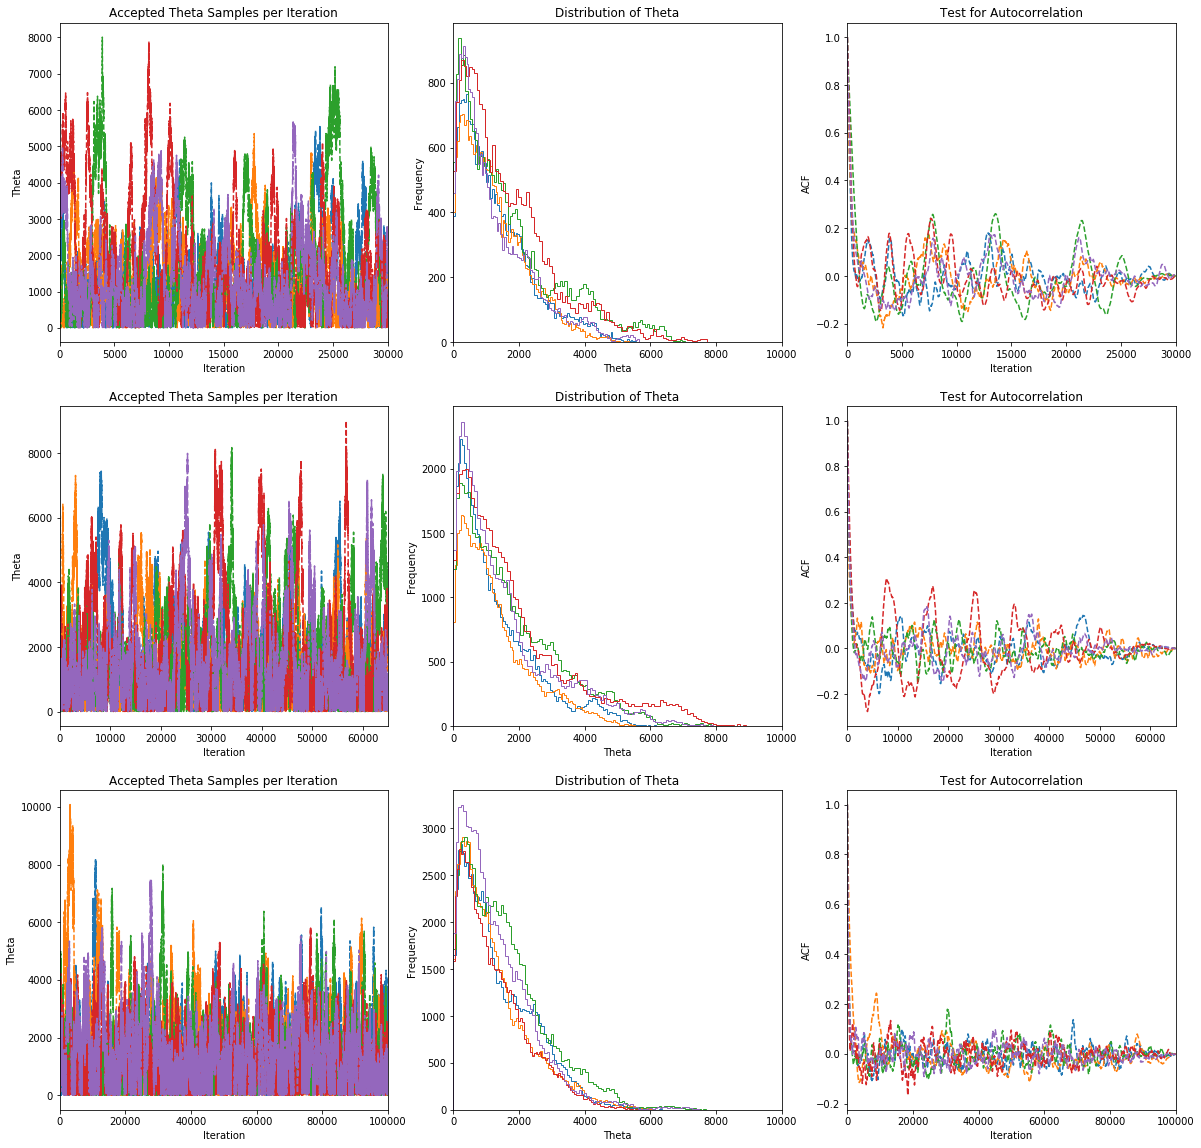

Wall time: 3min 42s


In [27]:
%%time
mcmc_samples = MCMC(shape, scale, niters = np.linspace(3e4,1e5,3), thetas = np.arange(1000, 3001, 500))

#### Result of MCMC Samples

In [40]:
a_i = b_i = 0
ab = [numericalMLEGamma(s) for s in mcmc_samples]
for x in ab:
    a_i += x[0]
    b_i += x[1]
print('Alpha: %s, Beta: %s' %(round(a_i/len(ab),1), round(b_i/len(ab),1)))
print('Mean infection count: %s' %(round(a_i/len(ab)*b_i/len(ab),1)))
print('Stddev infection count: %s' %(round(np.sqrt(a_i/len(ab)*b_i/len(ab)*b_i/len(ab)),1)))

Alpha: 1.3, Beta: 1110.7
Mean infection count: 1457.2
Stddev infection count: 1272.2


## Case 3: Simulate China, ex-Hubei infection numbers

In [95]:
case_exHubei = df[(df['Country']=='China')&(df['Province']!='Hubei')]

In [96]:
case_exHubei = case_exHubei.groupby('Date').agg({'Confirmed':'sum','Deaths':'sum','Recovered':'sum'}).reset_index()

In [97]:
case_exHubei['new infected'] = case_exHubei['Confirmed'].diff().fillna(1)

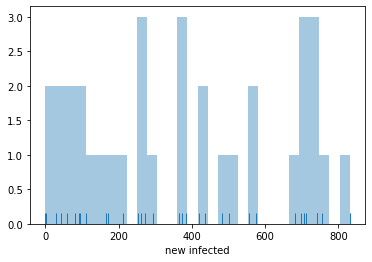

In [98]:
sb.distplot(case_exHubei['new infected'], bins=30, kde=False, rug=True)

In [105]:
mu = case_exHubei['new infected'].mean()
sigma = case_exHubei['new infected'].std()
mu, sigma

(377.38235294117646, 267.68129112535735)

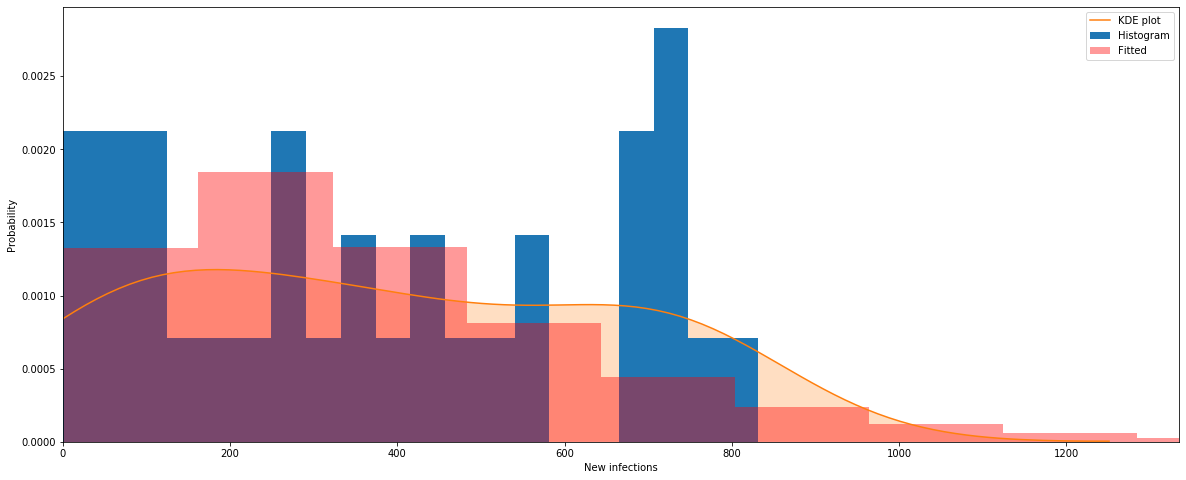

In [106]:
shape, scale = (mu/sigma)**2, sigma**2/mu
fig = plt.figure(figsize=(20,8))

gcount, gbins, ignored = plt.hist(case_exHubei['new infected'], bins=20, normed=True, label='Histogram')
sb.kdeplot(case_exHubei['new infected'], shade=True, label='KDE plot').set(xlim=(0))

g = np.random.gamma(shape, scale, 50000)
fcount, fbins, ignored = plt.hist(g, bins=20, normed=True, label='Fitted', alpha = 0.4, color='r')

plt.legend()
plt.ylabel("Probability")
plt.xlabel("New infections")
plt.show()

iter: 30000.0
Theta: 209.6, Mean of samples: 313.5, Stddev of samples: 201.2
Theta: 127.3, Mean of samples: 341.9, Stddev of samples: 208.8
Theta: 818.4, Mean of samples: 437.0, Stddev of samples: 324.5
Theta: 1230.8, Mean of samples: 386.4, Stddev of samples: 264.6
Theta: 283.0, Mean of samples: 339.8, Stddev of samples: 197.9
Gelman Rubin convergence ratio: 1.2158078184356236
iter: 65000.0
Theta: 260.3, Mean of samples: 369.7, Stddev of samples: 244.1
Theta: 412.5, Mean of samples: 355.1, Stddev of samples: 249.0
Theta: 191.8, Mean of samples: 343.8, Stddev of samples: 222.2
Theta: 92.2, Mean of samples: 383.4, Stddev of samples: 256.9
Theta: 177.9, Mean of samples: 347.0, Stddev of samples: 223.6
Gelman Rubin convergence ratio: 1.1845602937812825
iter: 100000.0
Theta: 359.4, Mean of samples: 386.0, Stddev of samples: 267.6
Theta: 396.3, Mean of samples: 394.6, Stddev of samples: 278.7
Theta: 138.3, Mean of samples: 440.3, Stddev of samples: 309.7
Theta: 262.2, Mean of samples: 430.3

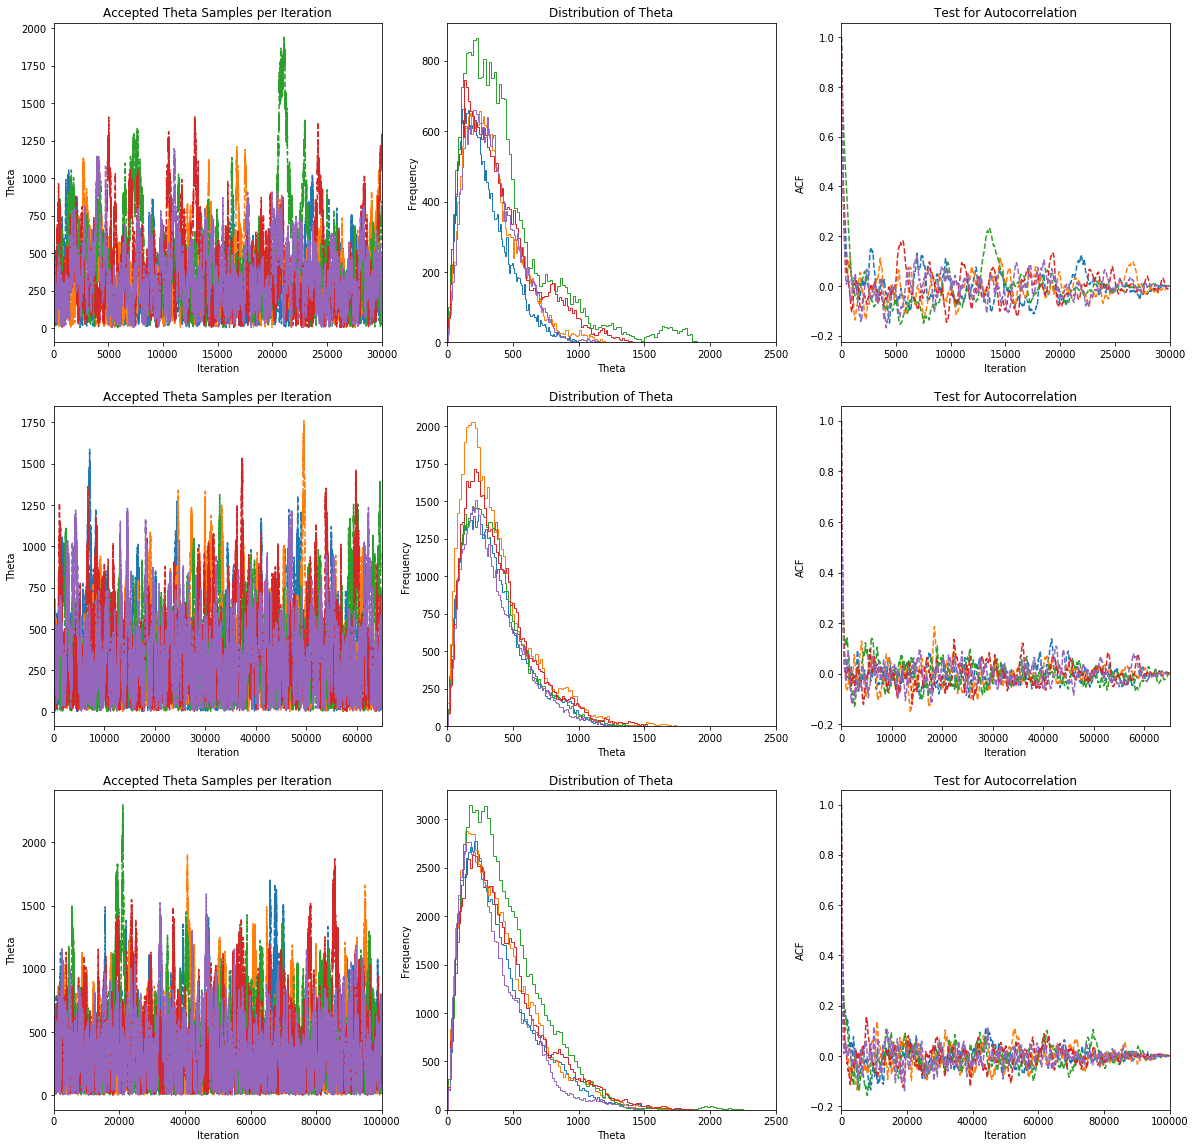

Wall time: 3min 48s


In [107]:
%%time
mcmc_samples = MCMC(shape, scale, sigma=25, niters = np.linspace(3e4,1e5,3), thetas = np.arange(10, 411, 100))

### Result of MCMC Samples

In [108]:
a_i = b_i = 0
ab = [numericalMLEGamma(s) for s in mcmc_samples]
for x in ab:
    a_i += x[0]
    b_i += x[1]
print('Alpha: %s, Beta: %s' %(round(a_i/len(ab),1), round(b_i/len(ab),1)))
print('Mean infection count: %s' %(round(a_i/len(ab)*b_i/len(ab),1)))
print('Stddev infection count: %s' %(round(np.sqrt(a_i/len(ab)*b_i/len(ab)*b_i/len(ab)),1)))

Alpha: 2.1, Beta: 194.3
Mean infection count: 402.0
Stddev infection count: 279.5


## Case 4: Simulate ex-China infection numbers

In [109]:
case_exChina = df[(df['Country']!='China')]

In [110]:
case_exChina = case_exChina.groupby('Date').agg({'Confirmed':'sum','Deaths':'sum','Recovered':'sum'}).reset_index()

In [111]:
case_exChina['new infected'] = case_exChina['Confirmed'].diff().fillna(1)

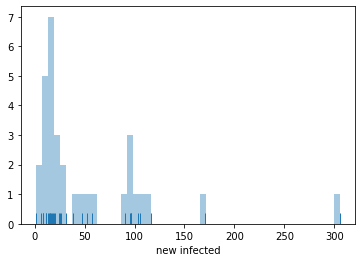

In [112]:
sb.distplot(case_exChina['new infected'], bins=50, kde=False, rug=True)

In [120]:
case_exChina = case_exChina[case_exChina['new infected']<250]
mu = case_exChina['new infected'].mean()
sigma = case_exChina['new infected'].std()
mu, sigma

(44.0, 42.88278597914708)

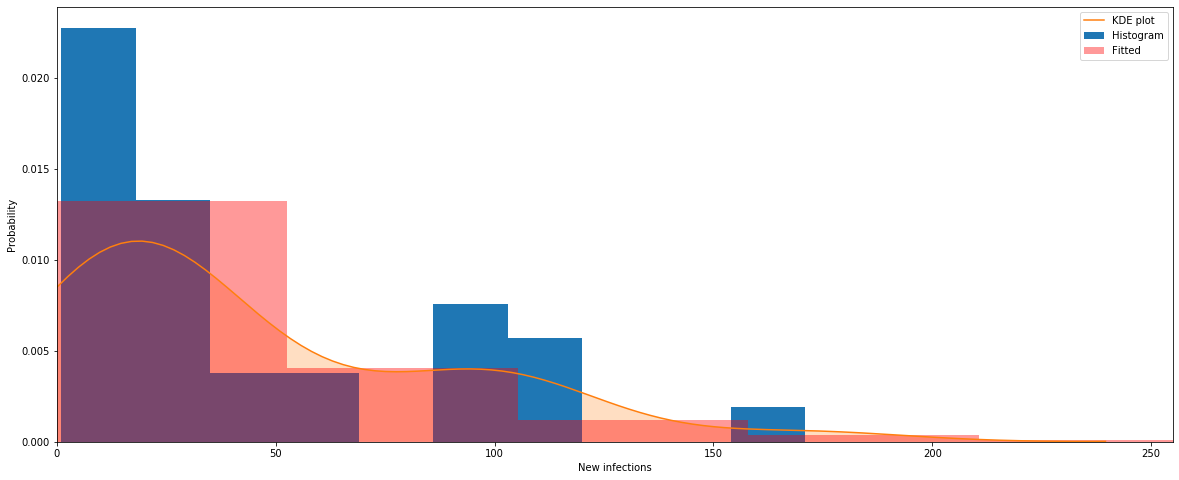

In [121]:
shape, scale = (mu/sigma)**2, sigma**2/mu
fig = plt.figure(figsize=(20,8))

gcount, gbins, ignored = plt.hist(case_exChina['new infected'], bins=10, normed=True, label='Histogram')
sb.kdeplot(case_exChina['new infected'], shade=True, label='KDE plot').set(xlim=(0))

g = np.random.gamma(shape, scale, 50000)
fcount, fbins, ignored = plt.hist(g, bins=10, normed=True, label='Fitted', alpha = 0.4, color='r')

plt.legend()
plt.ylabel("Probability")
plt.xlabel("New infections")
plt.show()

iter: 30000.0
Theta: 51.4, Mean of samples: 54.2, Stddev of samples: 61.5
Theta: 74.2, Mean of samples: 51.1, Stddev of samples: 49.0
Theta: 28.1, Mean of samples: 52.7, Stddev of samples: 52.8
Theta: 44.3, Mean of samples: 48.5, Stddev of samples: 45.6
Theta: 37.4, Mean of samples: 51.5, Stddev of samples: 50.7
Gelman Rubin convergence ratio: 1.1879019988607318
iter: 65000.0
Theta: 58.8, Mean of samples: 45.7, Stddev of samples: 39.7
Theta: 102.8, Mean of samples: 48.4, Stddev of samples: 42.9
Theta: 45.9, Mean of samples: 46.2, Stddev of samples: 40.8
Theta: 3.4, Mean of samples: 49.2, Stddev of samples: 46.8
Theta: 142.1, Mean of samples: 50.3, Stddev of samples: 45.0
Gelman Rubin convergence ratio: 1.184061848210451
iter: 100000.0
Theta: 99.8, Mean of samples: 46.4, Stddev of samples: 41.5
Theta: 103.6, Mean of samples: 43.0, Stddev of samples: 37.9
Theta: 25.3, Mean of samples: 50.3, Stddev of samples: 46.9
Theta: 54.1, Mean of samples: 47.8, Stddev of samples: 43.9
Theta: 107.9, 

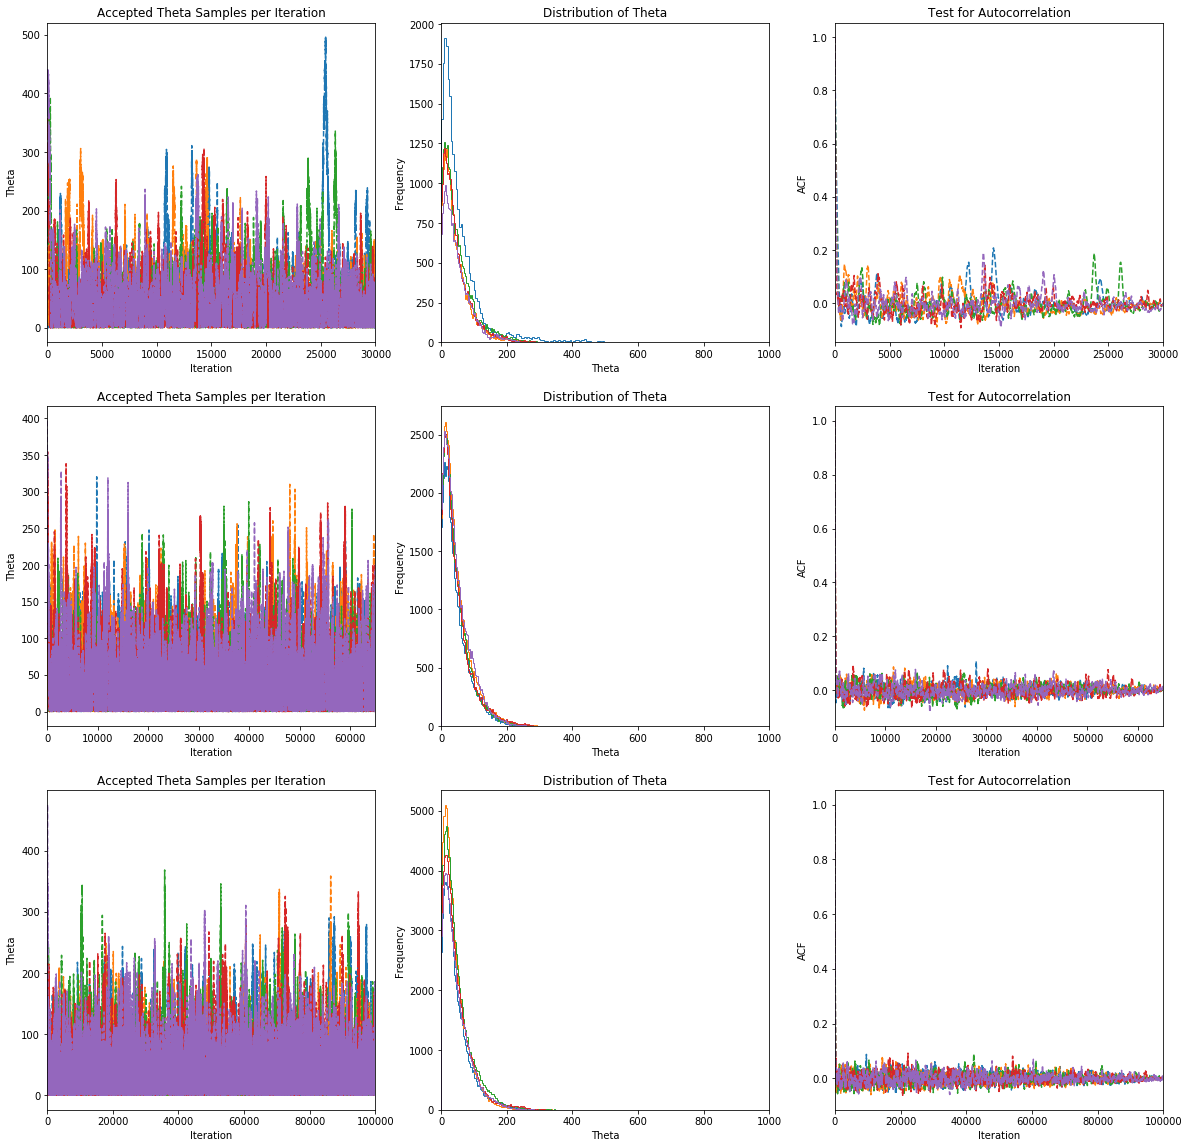

Wall time: 4min 15s


In [123]:
%%time
mcmc_samples = MCMC(shape, scale, sigma=10, niters = np.linspace(3e4,1e5,3), thetas = np.arange(10, 411, 100))

## Result of MCMC Samples

In [124]:
a_i = b_i = 0
ab = [numericalMLEGamma(s) for s in mcmc_samples]
for x in ab:
    a_i += x[0]
    b_i += x[1]
print('Alpha: %s, Beta: %s' %(round(a_i/len(ab),1), round(b_i/len(ab),1)))
print('Mean infection count: %s' %(round(a_i/len(ab)*b_i/len(ab),1)))
print('Stddev infection count: %s' %(round(np.sqrt(a_i/len(ab)*b_i/len(ab)*b_i/len(ab)),1)))

Alpha: 1.2, Beta: 37.6
Mean infection count: 47.0
Stddev infection count: 42.1
